In [53]:
from autograd import grad
import autograd.numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

### The mnist data set
from fuel.datasets import MNIST
def get_data(datatype):
    mnist = MNIST((datatype,))
    state = mnist.open()
    im,_ = mnist.get_data(state=state, request=[i for i in range(int(mnist.num_examples))] )
    return im.reshape(im.shape[0],28*28)/255
data = get_data('train')
print(data.shape)

### Hyperparams
d = 784 #high d
m = 12 #low d - dim reduction

(60000, 784)


# Intro

An exploration into linear neural networks (while also learning linear algebra...). Also, in machine learning there is a old and somewhat famous [result](https://users.ics.aalto.fi/oja/Oja92.pdf) that linear autoencoders learn the principle components from PCA.

# PCA

What do we want to do? We want to find patterns in our data that can tell us about how the data is generated. So, one of the simplest ways to do this is to look at how each of the variables in our data change with each other. We can then use this to try to figure out how many variables our data actually has. For instance, if all of our variables increase with each other, then we could infer that they are all being generated by a single increasing variable.

### High level algorithm

* Find the covariance matrix.
* Find eigen vectors of covariance matrix.
* Pick principle components (aka eigenvectors) and apply.

### Covariance

We want to find out how each of our dimensions vary with each other one. 
* Does x change with y?
* Is x proportional to y?
* Is there a correlation between x and y?

So, according to wikipedia, the covariance of $X = X^T \cdot X $. This is the empirical approximation to the covariance, using data. Which is what we want.

So let's pick a simple example to play with, a (4,3) matrix of data samples/observations and features/dimensions.
$$
= \begin{bmatrix}
x_{1,1} & x_{2,1} & x_{3,1} \\
x_{1,2} & x_{2,2} & x_{3,2} \\
x_{1,3} & x_{2,3} & x_{3,3} \\
x_{1,4} & x_{2,4} & x_{3,4} \\
\end{bmatrix} 
\begin{bmatrix}
x_{1,1} & x_{1,2} & x_{1,3} & x_{1,4} \\
x_{2,1} & x_{2,2} & x_{2,3} & x_{2,4} \\
x_{3,1} & x_{3,2} & x_{3,3} & x_{3,4} \\
\end{bmatrix} \\
= \begin{bmatrix}
x_{1,1}x_{1,1} + x_{2,1}x_{2,1} + x_{3,1}x_{3,1} & x_{1,1}x_{1,2} + x_{2,1}x_{2,2} + x_{3,1}x_{3,2} & x_{1,1}x_{1,3} + x_{2,1}x_{2,3} + x_{3,1}x_{3,3} & x_{1,1}x_{1,4} + x_{2,1}x_{2,4} + x_{3,1}x_{3,4} \\
x_{1,2}x_{1,1} + x_{2,2}x_{2,1} + x_{3,2}x_{3,1} & x_{1,2}x_{1,2} + x_{2,2}x_{2,2} + x_{3,2}x_{3,2} & x_{1,2}x_{1,3} + x_{2,2}x_{2,3} + x_{3,2}x_{3,3} & x_{1,2}x_{1,4} + x_{2,2}x_{2,4} + x_{3,2}x_{3,4} \\
x_{1,3}x_{1,1} + x_{2,3}x_{2,1} + x_{3,3}x_{3,1} & x_{1,3}x_{1,2} + x_{2,3}x_{2,2} + x_{3,3}x_{3,2} & x_{1,3}x_{1,3} + x_{2,3}x_{2,3} + x_{3,3}x_{3,3} & x_{1,3}x_{1,4} + x_{2,3}x_{2,4} + x_{3,3}x_{3,4} \\
x_{1,4}x_{1,1} + x_{2,4}x_{2,1} + x_{3,4}x_{3,1} & x_{1,4}x_{1,2} + x_{2,4}x_{2,2} + x_{3,4}x_{3,2} & x_{1,4}x_{1,3} + x_{2,4}x_{2,3} + x_{3,4}x_{3,3} & x_{1,4}x_{1,4} + x_{2,4}x_{2,4} + x_{3,4}x_{3,4} \\
\end{bmatrix} \\
$$
Alternatively, we can view this matrix as the product of columns of X. Where $c_i$ indicates the ith column of X.
$$
= \begin{bmatrix}
c_1 \cdot c_1 & c_1 \cdot c_2 & c_1 \cdot c_3 & c_1 \cdot c_4 \\
c_2 \cdot c_1 & c_2 \cdot c_2 & c_2 \cdot c_3 & c_2 \cdot c_4 \\
c_3 \cdot c_1 & c_3 \cdot c_2 & c_3 \cdot c_3 & c_3 \cdot c_4 \\
c_4 \cdot c_1 & c_4 \cdot c_2 & c_4 \cdot c_3 & c_4 \cdot c_4 \\
\end{bmatrix}
$$

So what do entries of the covariance matrix really tell us? 
* Along the **diagonal** we have the sum of the squared values for a given column of X.
    * E.g. ```CoVar(X)[0,0]``` is $x_{1,1}x_{1,1} + x_{2,1}x_{2,1} + x_{3,1}x_{3,1} = c_1 \cdot c_1$
* The rest of the elements (**off-diagonal**) are the dot product of two different columns of X.
    * E.g. ```CoVar(X)[3,0]``` is $x_{1,4}x_{1,1} + x_{2,4}x_{2,1} + x_{3,4}x_{3,1} = c_4\cdot c_1$
    * Which is equivalent to the dot product of column 1 with column 4. 

Now comes the complicated part. $(-) \times (-) = (+), (+) \times (+) = (+), (-) \times (+) = (-)$ We can see that if two column entries, $x_{ij} x_{mn}$, have the same sign, so are in some binary-sense correlated, then they will result in a position value. If not, negative. From this, it is easily seen that when the elements of two columns are more similar, the higher the correlation. So for the diagonal entries we would expect to have values on 1.

The key to this is the mean normalisation. The columns are normalised, so increasing the absolute value of a column will not necessarily result in higher correlation.

# Whitening data

Let; 
* E be a matrix of stacked eigenvectors
* V be the eigenvalues
* M be some matrix e.g. covariance

We can write the diagonalized covariance as: $V = E^TME$. 
So decorrelated variables, is the set eigenvalues. Why/how does this make sense? Isnt this almost exactally what PCA is doing???

Therefore if we set $y= E^Tx$ then y is a decorelated representation of x. (???)

##### Questions
* Can all matrices be decorrelated? Does this depend on rank?
* Where do the damned eigenvectors come from? Why is it that there (must??) exist a set of orthogonal axes that each ...

##### Resources
* http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf
* https://theclevermachine.wordpress.com/2013/03/30/the-statistical-whitening-transform/

In [54]:
def normalise(x):
    #should i be normalising the variances?
    return (x-np.mean(x,0).reshape((1,x.shape[1]))) / np.sqrt(np.var(x,0).reshape((1,x.shape[1])) + 1e-10)
ims = normalise(data)
print(np.mean(ims))
print(np.var(ims)) #I would have expected this to be closer to 1?? why not?

5.10910721137e-14
0.914516197567


In [55]:
my_covar = np.dot(ims.T , ims)*(1/(ims.shape[0]))
their_covar = np.cov(ims.T)
print('My covariance = ',np.mean(my_covar))
print('Numpys approximation of the covariance = ',np.mean(their_covar))

My covariance =  0.0190661292555
Numpys approximation of the covariance =  0.0190664470296


In [56]:
eigenvals,eigenvecs = np.linalg.eig(my_covar)
#check they are unit vectors. #why is this important?
print('Norm of eigen vector = {:.2f}'.format(np.linalg.norm(eigenvecs[:,0])))
print(eigenvals[0:m])

Norm of eigen vector = 1.00
[ 40.48696004  29.24120976  26.81135733  20.68627192  18.07634853
  15.73291534  13.79037854  12.51737991  11.00661076  10.05032909
   9.62029682   8.63082826]


In [57]:
#Ax =ax => Axx-1 = a
x = eigenvecs[:,0]
print(np.dot(np.dot(my_covar,x).reshape((1,784)),x))

[ 40.48696004]


In [58]:
principle_component_directions = eigenvecs[:,0:m] #take the first 5 dimensions
transform = np.dot(ims,principle_component_directions)
#why does this work? we are multiplying the ???
transform.shape

(60000, 12)

In [59]:
def plotter(x):
    plt.figure(figsize=(16,16))
    for i in range(m):
        plt.subplot(math.ceil(m/3),3,i+1)
        plt.imshow(x[:,i].reshape(28,28),cmap='Greys_r')
        plt.title('Component {}'.format(i))

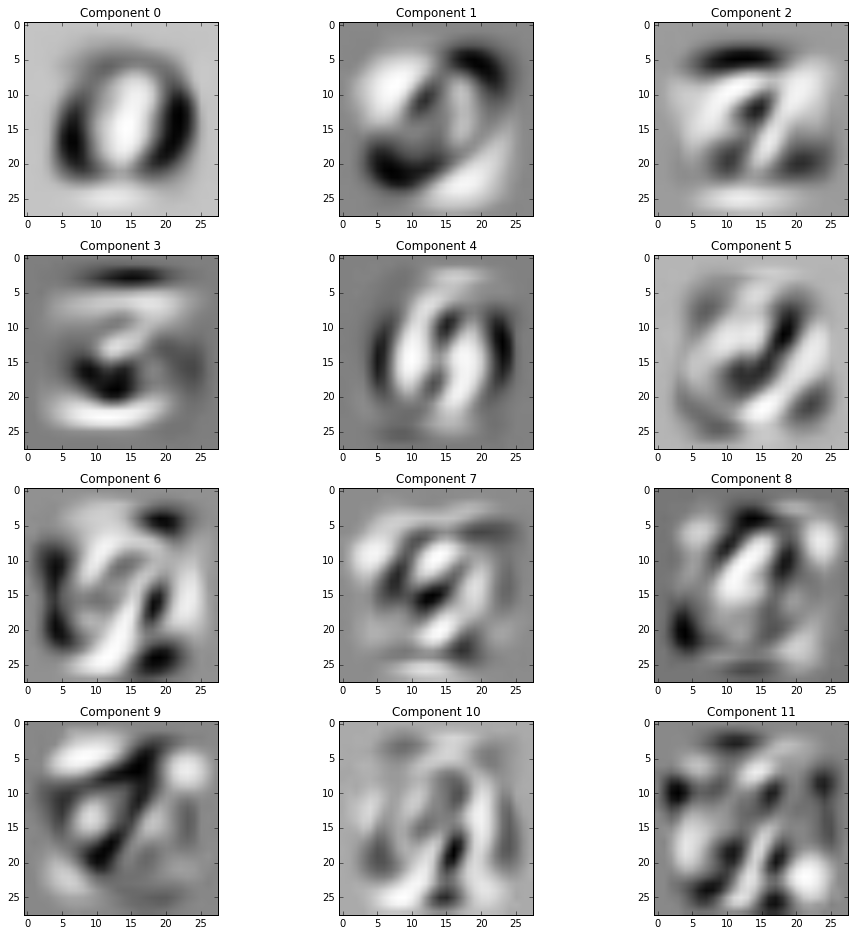

In [60]:
plotter(principle_component_directions)

In [87]:
# Reconstruction error of PCA
# reconstruct the images by transofrming the data into the selected compoents and then back.
def Squared_Error(x,y):
    return np.mean(np.sum((x - y)**2,axis=1))  

PCA_reconstruction = np.dot(np.dot(ims,principle_component_directions),principle_component_directions.T)
print('The reconstruction error of PCA with {} features is {}'.format(m,Squared_Error(PCA_reconstruction,ims)))

The reconstruction error of PCA with 12 features is 500.3298125981209


/Users/act65/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The reconstruction error of PCA with 0.0 features is 716.98 which is -0.030%
The reconstruction error of PCA with 28.0 features is 401.86 which is 0.423%
The reconstruction error of PCA with 56.0 features is 304.96 which is 0.562%
The reconstruction error of PCA with 84.0 features is 241.05 which is 0.654%
The reconstruction error of PCA with 112.0 features is 191.01 which is 0.726%
The reconstruction error of PCA with 140.0 features is 153.33 which is 0.780%
The reconstruction error of PCA with 168.0 features is 123.16 which is 0.823%
The reconstruction error of PCA with 196.0 features is 98.14 which is 0.859%
The reconstruction error of PCA with 224.0 features is 79.29 which is 0.886%
The reconstruction error of PCA with 252.0 features is 66.65 which is 0.904%
The reconstruction error of PCA with 280.0 features is 54.16 which is 0.922%
The reconstruction error of PCA with 308.0 features is 43.96 which is 0.937%
The reconstruction error of PCA with 336.0 features is 36.01 which is 0.9

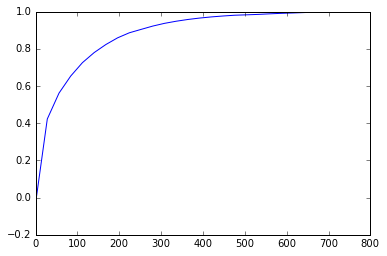

In [88]:
# how does the reconstruction error depend on the amount of 
I = 28+1
k = np.zeros(I)
feat_err = np.zeros(I)
feat_err_percent = np.zeros(I)
for i in range(I):
    k[i] = 28*(i)
    PCA_recon = np.dot(np.dot(ims,eigenvecs[:,0:k[i]]),eigenvecs[:,0:k[i]].T)
    feat_err[i] = Squared_Error(PCA_recon,ims)
    feat_err_percent[i] = (695.9-feat_err[i])/695.9
    print('The reconstruction error of PCA with {} features is {:.2f} which is {:.3f}%'
          .format(k[i],feat_err[i],feat_err_percent[i]))
plt.plot(k,feat_err_percent)

We get diminishing returns on adding more features. This makes sense as we know from our eariler analysis that the directions the eigenvectors give us account for less variance.

### Questions
* So, this related to overfitting? How do we know when we are using too many dimensions/features? 
* So the direction/eigenvector that gives the most variance looks remarkably like a zero. (why??)
* In what sense are each of these images orthogonal to each other?
* Also, we would expect that an autoencoder with n nodes in its bottle neck can do no better than these values (????)
* How do we actally find the eigen vectors? Optimisation?

In [62]:
M = np.zeros((2,2)) + 1
print(M)
U,S,V = np.linalg.svd(M)
print(U)
print(S)
print(V)

[[ 1.  1.]
 [ 1.  1.]]
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[  2.00000000e+00   3.35470445e-17]
[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]


In [63]:
### Using numpy - covariance and SVD
U, S, V = np.linalg.svd(their_covar, full_matrices=True)
print('Principle component variance = ',np.max(S))

Principle component variance =  40.4876348291


In [64]:
### Using sklearn's PCA
pca = PCA(n_components=5,whiten=True)
pca.fit(data)
print('Principle component variance = ',pca.explained_variance_)

Principle component variance =  [ 5.11678773  3.74132848  3.25265424  2.84157334  2.56707496]


## Autoencoders

So now we are ready to test out how if a linear autoencoder learns PCA.


Should I be normalising the columns of the weights? Why was this important in PCA?

In [127]:
def LinearAE(w,x): #a two layer encoder-decoder
    return np.dot(np.dot(x,w['W1']),w['W2'])

def Loss(w,x): #squared error
    return Squared_Error(x , LinearAE(w,x))
dL = grad(Loss) #the magic of autograd

def train(w,dL):
    #A simple two layer linear autoencoder
    N = 100000
    lr = 0.0001
    indicies = [n for n in range(data.shape[0])]
    batch_size = 50
    for i in range(N):
        #stochastic gradient descent
        batch = data[np.random.randint(0,data.shape[0],batch_size),:]  #train on mini-batches
        dLdw = dL(w,batch)
        for grads in dLdw: #update rule - follow the gradient downhill
            w[grads] -= lr * dLdw[grads]
        if i%30 == 0:
            print("\r Loss = {}".format(Loss(w,batch)),end='')
    return w

 Loss = 15.551854521130801
The reconstruction error of a linear AE with 12 features is 15.045184878758933


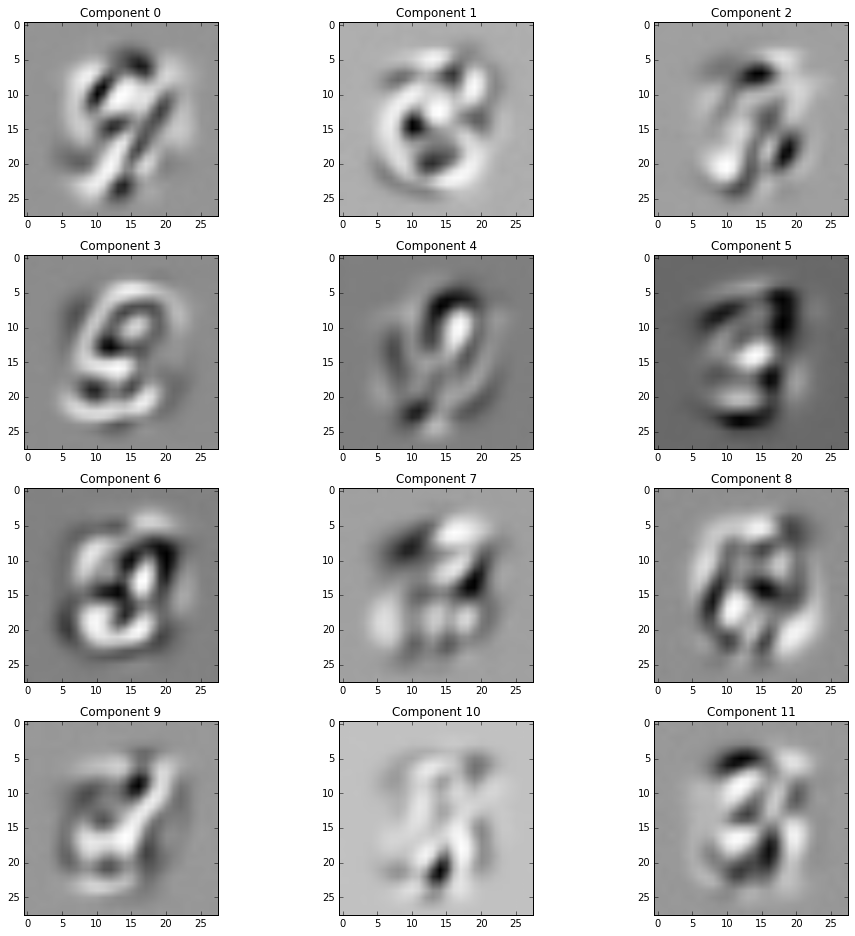

In [128]:
Weights={}
Weights['W1'] = 0.001*np.random.standard_normal((784,28))
Weights['W2'] = 0.001*np.random.standard_normal((28,784))
Weights = train(Weights,dL)
plotter(Weights['W1'])
print('\nThe reconstruction error of a linear AE with {} features is {}'.format(m,Squared_Error(LinearAE(Weights,data), data)))

This seems unusual? The autoencoder did better than PCA. The NN can overfit to data?

As we can see, it has learnt a couple of the principle components, but not others. The problem is the stochastic nature of training. The smapling method I am using means that some datapoints may not even be trained on... 

In [129]:
#tanh network
def NonLinearAE(w,x): #a two layer encoder-decoder
    return np.tanh(np.dot(np.tanh(np.dot(x,w['W1'])),w['W2']))

def SigmoidLoss(w,x): #squared error
    return Squared_Error(x , NonLinearAE(w,x))
nonlindL = grad(SigmoidLoss) #the magic of autograd

 Loss = 39.60926096867142
The reconstruction error of a linear AE with 12 features is 40.50459070331079


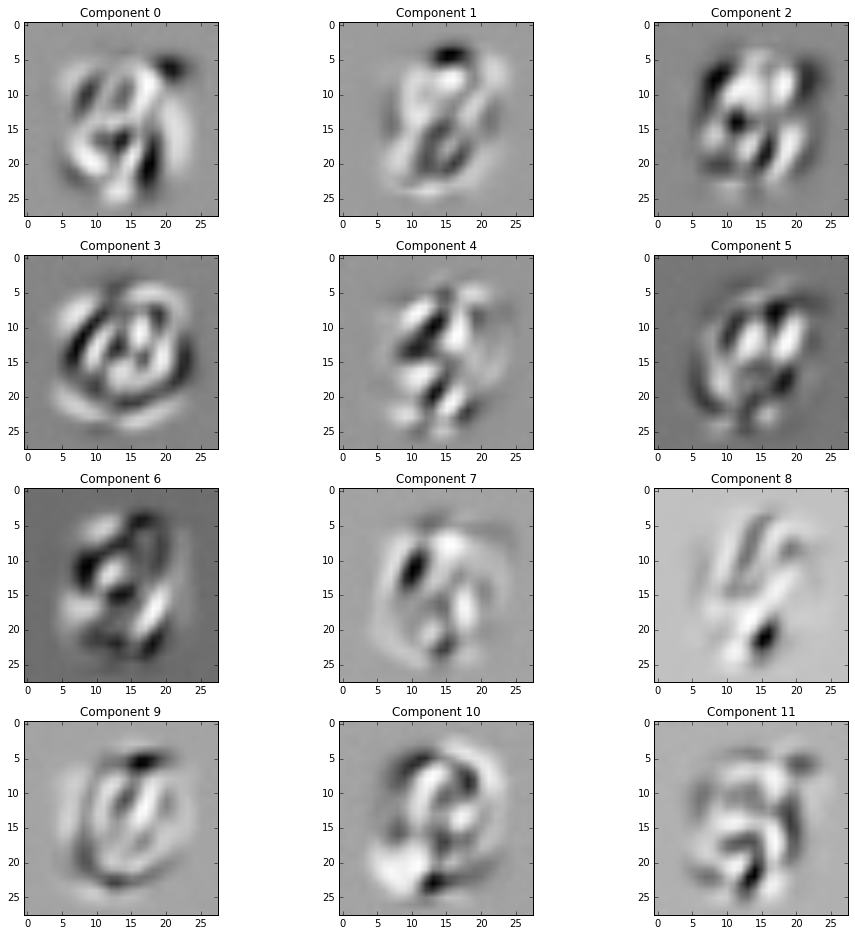

In [130]:
Weights={}
Weights['W1'] = 0.001*np.random.standard_normal((784,28))
Weights['W2'] = 0.001*np.random.standard_normal((28,784))
Weights = train(Weights,nonlindL)
plotter(Weights['W1'])
print('\nThe reconstruction error of a linear AE with {} features is {}'.format(m,Squared_Error(LinearAE(Weights,data), data)))

In [131]:
#relu network
def NonLinearAE(w,x): #a two layer encoder-decoder
    return np.max(np.dot(np.max(np.dot(x,w['W1']),0),w['W2']),0)

def SigmoidLoss(w,x): #squared error
    return Squared_Error(x , NonLinearAE(w,x))
nonlindL = grad(SigmoidLoss) #the magic of autograd

 Loss = 87.60359002654344
The reconstruction error of a linear AE with 12 features is 87.8227472336007


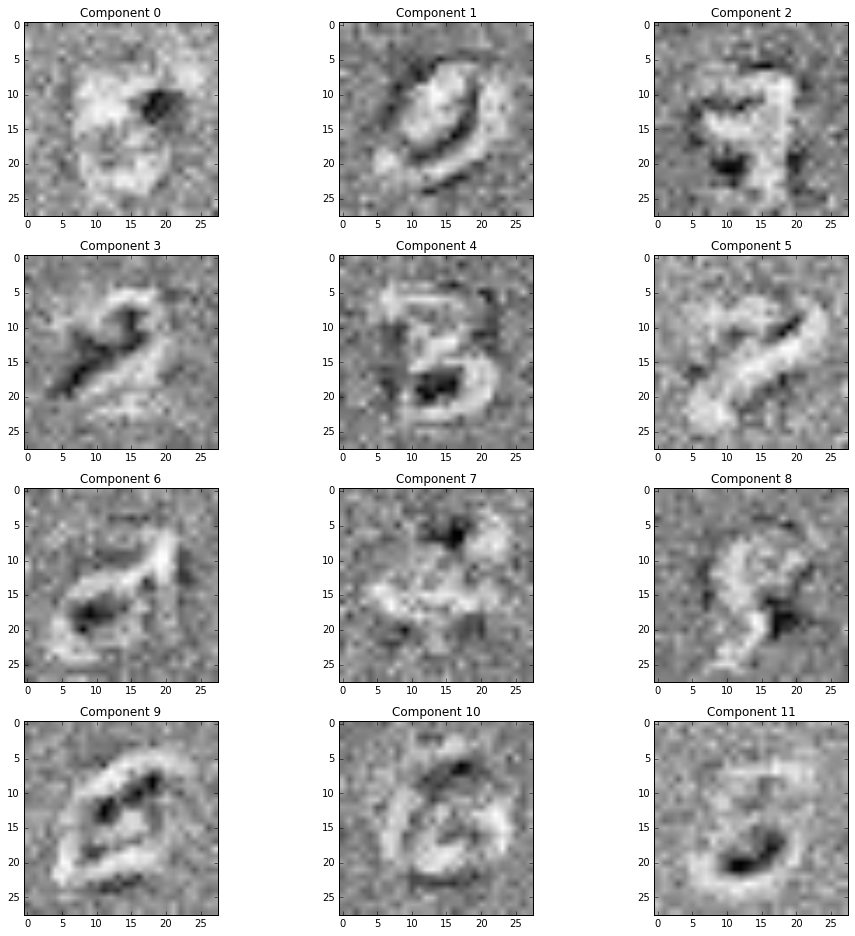

In [132]:
Weights={}
Weights['W1'] = 0.001*np.random.standard_normal((784,28))
Weights['W2'] = 0.001*np.random.standard_normal((28,784))
Weights = train(Weights,nonlindL)
plotter(Weights['W1'])
print('\nThe reconstruction error of a linear AE with {} features is {}'.format(m,Squared_Error(LinearAE(Weights,data), data)))

In [108]:
#Find the variance explained by the learned weights aka feature vectors
#Ax = ax => (Ax)x-1 = a 
def find_variance_explained(x):
    eigen_variances = []
    for i in range(m):
        #this is not the right way to do it... pretty sure i am cheating with the mean/median?
        #mean doesnt work because of all the zeros.
        eigen_variances.append( np.median(np.dot(my_covar, x[:,i]) / (x[:,i]+1e-15)))
    print(eigen_variances)
find_variance_explained(principle_component_directions)
find_variance_explained(Weights['W1'])

[40.486960035191707, 29.241209763574815, 26.811357329429129, 20.686271915342779, 18.07634853003227, 15.732915341637536, 13.790378544361772, 12.517379908256181, 11.006610759002193, 10.05032908729371, 9.620296821226896, 8.6308282591208521]
[16.760503507922394, 21.447776453093578, 9.5043456762192271, 15.832759141415718, 14.42090765028405, 14.642483301152506, 16.176650025619949, 9.8099574382404207, 8.5700173056438587, 16.912739962686565, 10.173504509258592, 10.210363590151941]


## NNs and PCA  (Baldi et al. 1989/2012)

### Summary
1. Show that each critical point of $E(A,B)$ is some combination of principle components of $\Sigma$, which are the eigen vectors of the covariance matrix of our data. (is that true?)
* Show that the minium loss is achieved when the largest eigenvalues/leading eigenvectors are chosen/learnt.

***

$$
\begin{align}
E(A,B) = \sum_t \parallel y^t - ABx^t \parallel \tag{a} \\
A^T(AB - \Sigma_{YX}\Sigma^{-1}_{XX}) = 0 \\
S = AB - P_A \Sigma_{YX}\Sigma^{-1}_{XX} \\
\end{align}
$$
To show (1) they set A and solve for B given $E(A,B)$ is at a critical point (aka that the gradient of loss is zero) -- and vice versa. Using this result we find that AB is equal to the projection of the covariance YX and the inverse of covariance XX into a subspace of A (using a clever argument to show that $S = 0$, as S is both in the subspace of A and orthogonal to A). It follows that $\Sigma$ is invariant to the columns of A, which is (roughly) the definition of an eigen vector. 

To show (2) we use a unitary change of coordinates, where the covariance XX is diagonal, to allow some nice rearranging. Because AB is a projection matrix we know that we can drop the aquared term, thus we can cancel we can simplity to the trace of $tr(\Sigma) - tr(AB\Sigma)$. Then using pertubation analysis of ...

### Questions and notes

* We did second order optimisation without computing the hessian.
* SVD proof of projection?!?
* What was the most important part of this paper? How significant is that that we could describe the loss surface?

### Resources
* https://en.wikipedia.org/wiki/Covariance_matrix
* http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf
* http://mengnote.blogspot.co.nz/2013/05/an-intuitive-explanation-of-pca.html
* [Principle components, minor components and linear networks - Oja](https://users.ics.aalto.fi/oja/Oja92.pdf)
* [Neural Networks and Principal Component Analysis: Learning from Examples Without Local Minima](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.408.1839&rep=rep1&type=pdf)
* [Mixtures of Probabilistic Principal Component Analysers](http://www.miketipping.com/papers/met-mppca.pdf)
* http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues